In [16]:
import pandas as pd
import networkx as nx
from typing import List
from time import time
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [8]:
'''this is the part where the data is preprocessed'''
def data_preprocessing(df: pd.DataFrame,date=None) -> pd.DataFrame:
    # drop rows where the buyer and seller are the same
    df = df.drop(df[df['seller'] == df['buyer']].index)
    # drop to 0 price rows
    df = df.drop(df[df['price'] == 0].index)
    # reindex the dataframe
    df = df.reset_index(drop=True)
    # find the date columns which is match with the date parameter
    if date is not None:
        df = df[df['date'] == date]
    else:
        # find the date object which is the most frequent
        date = df['date'].value_counts().idxmax()
        df = df[df['date'] == date]
    return df

In [9]:
'''this is the part where the cycles are checked if they are really cycles in the dataframe'''
def cycle_check(cycles: List, df: pd.DataFrame, sellers: List, buyers: List) -> bool:

        # check the all cycles really are cycles in df
        for cycle in cycles:
            cycle_len = len(cycle)
            for i in range(cycle_len):
                seller = cycle[i]
                buyer = cycle[(i + 1) % cycle_len]
                # check if the cycle is in the dataframe
                indices = np.where((sellers == seller) & (buyers == buyer))[0]
                if len(indices) == 0:
                    raise Exception('Cycle not in dataframe')

In [13]:
def unwash(df: pd.DataFrame) -> pd.DataFrame:
    # take the sellers, buyers and prices columns from the dataframe
    sellers = df['seller'].values
    buyers = df['buyer'].values
    prices = df['price'].values

    # create a directed multigraph
    G = nx.MultiDiGraph()

    # add the edges to the graph
    G.add_weighted_edges_from(np.column_stack((sellers, buyers, prices)))

    # create a list to store the cycles
    cycles = []

    # get the cycles in the graph which are of length 3 or less
    for cycle in nx.simple_cycles(G,3):
        cycles.append(cycle)

    # save the cycles list to a pickle file
    # with open('cycles.pkl', 'wb') as f:
    #     pickle.dump(cycles, f)
    # # open the cycles list from the pickle file
    # with open('cycles.pkl', 'rb') as f:
    #      cycles = pickle.load(f)


    # collect indices to be dropped in a numpy array
    cyclic_indices = np.array([])


    # iterate over the cycles in the cycles list
    for cycle in cycles:
        cycle_len = len(cycle)
        for i in range(cycle_len):
            seller = cycle[i]
            buyer = cycle[(i + 1) % cycle_len]
            indices = np.where((sellers == seller) & (buyers == buyer))[0]
            cyclic_indices = np.append(cyclic_indices, indices)


    # remove duplicates from the indices_to_drop list
    cyclic_indices = np.unique(cyclic_indices).astype(int)
    
    return df.iloc[cyclic_indices]

    '''if the user wants to see all transaction cycles transaction_hash values values, the following code can be used'''
    # take the transaction_hash values to be dropped from the dataframe
    #return df.iloc[cyclic_indices]['transaction_hash'].values
    
    '''if the user wants to drop the rows from the dataframe, the following code can be used'''
    # drop the rows from the dataframe
    # df = df.drop(cyclic_indices)
    # return df

In [ ]:
def test_unwash():
    # take the data from the csv file
    df = pd.read_csv('2022-09-08_eth.csv')
    # preprocess the data
    df = data_preprocessing(df)
    start = time()
    expected_vol = 424242 # not disclosed

    vol_u = df.pipe(unwash).price.sum()
    # print the volume of the unwashed data
    print("Volume of the unwashed data: ", vol_u)
    assert abs((expected_vol - vol_u) / expected_vol) < 0.4
    assert round(time() - start) < 15 * 60

In [15]:
print(test_unwash())

Volume of the unwashed data:  295260.94584008615
None


In [17]:
def marketplace_dau(df: pd.DataFrame) -> pd.DataFrame:
    # find unique marketplaces names
    marketplaces = df['marketplace_name'].unique()
    # iterate over the marketplaces
    row_list = []
    for marketplace in marketplaces:
        dict_1 = {}
        # find the rows with the marketplace name
        df_marketplace = df[df['marketplace_name'] == marketplace]
        # find the unique users in buyers and sellers
        users = np.unique(np.concatenate((df_marketplace['buyer'].values, df_marketplace['seller'].values)))
        # find the number of unique users
        DAU = len(users)
        # find the volume
        volume = df_marketplace['price'].sum()
        # update the dictionary with the marketplace name, volume and DAU
        dict_1.update({'marketplace_name': marketplace, 'volume': volume, 'DAU': DAU})
        # append the dictionary to the row list
        row_list.append(dict_1)
    # create a dataframe from the row list
    df_marketplace_dau = pd.DataFrame(row_list)

    return df_marketplace_dau

In [18]:
df = pd.read_csv('2022-09-08_eth.csv')
print(marketplace_dau(df))

   marketplace_name         volume    DAU
0                 -  315765.137557  83587
1              x2y2    4600.576786   2498
2               gem     898.824129   7676
3           opensea    8810.059454  35422
4        foundation       6.856000    558
5         looksrare    1972.797927    246
6          sudoswap      95.269463    621
7                0x      26.955200     71
8           rarible      19.779840     20
9         larvalabs       0.000000     14
10            genie      58.473640    186


In [19]:
def top5_collections_plot(df: pd.DataFrame) -> List[pd.DataFrame]:
    # find unique collections
    collections = df['collection_name'].unique()
    # iterate over the collections
    collection_volume_dict = {}
    for collection in collections:
        # find the rows with the collection name
        df_collection = df[df['collection_name'] == collection]
        # find the volume
        volume = df_collection['price'].sum()
        collection_volume_dict[collection] = volume
    # take the top 5 collections
    top5_collections = sorted(collection_volume_dict, key=collection_volume_dict.get, reverse=True)[:5]
    # iterate over the top 5 collections
    for collection in top5_collections:
        # find the rows with the collection name
        df_collection = df[df['collection_name'] == collection]
        # plot 5 different graphs for each hour of the day for each collection. X axis is 24 hours and Y axis is DAU and average sale price
        hourly_dau = []
        hourly_average_sale_price = []
        # iterate over the hours
        for hour in range(24):
            # find the rows with the hour
            df_hour = df_collection[df_collection['hour'] == hour]
            # find the unique users in buyers and sellers
            users = np.unique(np.concatenate((df_hour['buyer'].values, df_hour['seller'].values)))
            # find the number of unique users
            hourly_dau.append(len(users))
            # find the volume
            volume = df_hour['price'].sum()
            # find the average sale price
            if df_hour.shape[0] == 0:
                average_sale_price = 0
                hourly_average_sale_price.append(average_sale_price)
            else:
                average_sale_price = volume / df_hour.shape[0]
                hourly_average_sale_price.append(average_sale_price)
        # create new df for each collection
        df_collection_plot = pd.DataFrame({'hourly_dau': hourly_dau, 'hourly_average_sale_price': hourly_average_sale_price}, index=[i for i in range(24)])
        # plot the graphs
        df_collection_plot.plot.line()
        plt.title(collection)
        plt.savefig(collection + '.png')

None


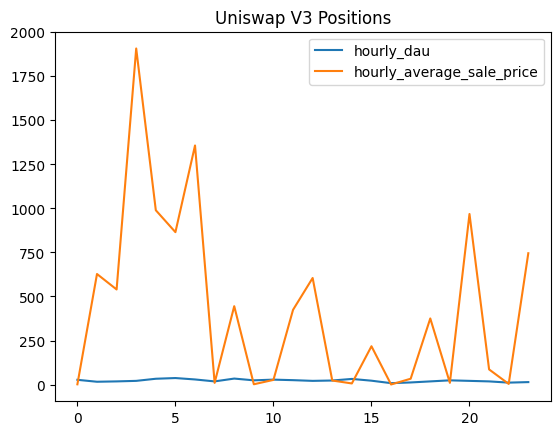

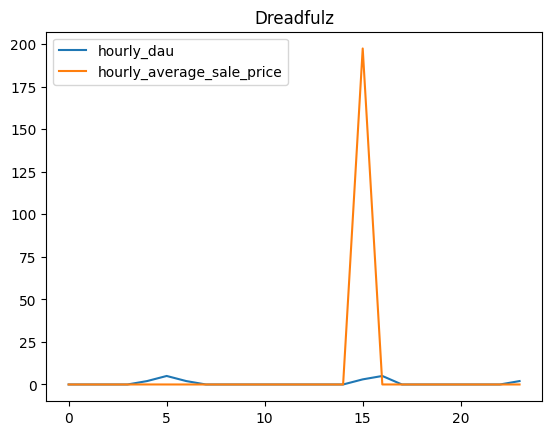

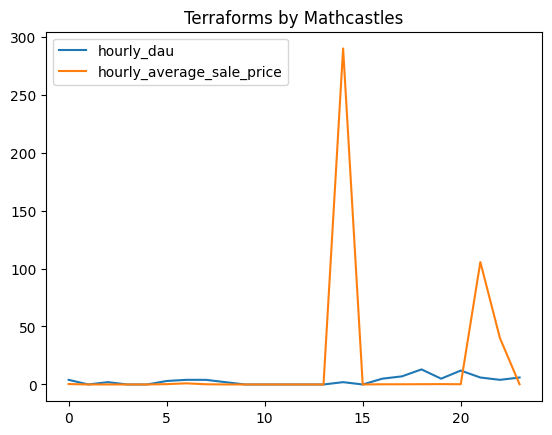

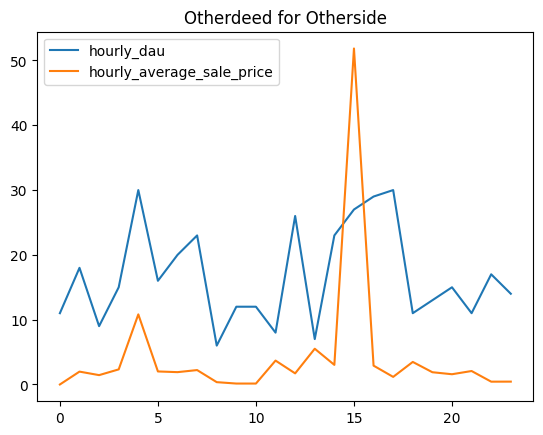

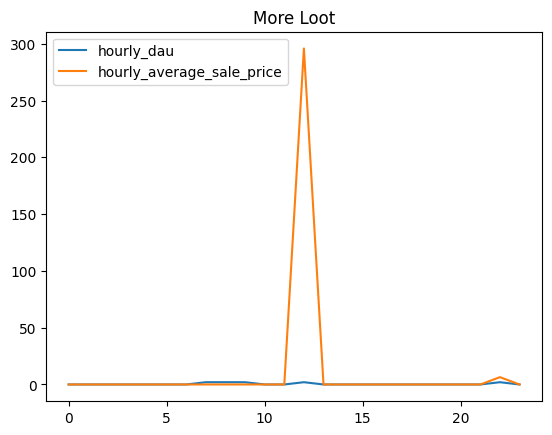

In [20]:
df = pd.read_csv('2022-09-08_eth.csv')
print(top5_collections_plot(df))